In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LSTM
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2, l1_l2

In [ ]:
# store csv contents in dataframe
file_path = "/content/Tweets.csv"

df = pd.read_csv(file_path)

In [ ]:
# drop rows/col with null values and only keep text and airline_sentiment columns
df = df[['text', 'airline_sentiment']].dropna()

In [ ]:
# categorical labels converted to integer labels
# neutral, positive, negative => 0 and 1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['airline_sentiment'])

# converts labels into vectors
y = to_categorical(y)

In [ ]:
tokenizer = Tokenizer(oov_token=1)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = 30
batch_size = 32
epochs = 20

In [ ]:
# add padding (zeroes) at the end
X = np.array(pad_sequences(sequences, maxlen=max_length, padding='post'))

In [ ]:
# helps deal with large data sets by doing on-the-fly data encoding in batches
class OneHotDataGenerator(Sequence):

  def __init__(self, X, y, batch_size, vocab_size):

    self.X = X
    self.y = y
    self.batch_size = batch_size
    self.vocab_size = vocab_size
    self.indexes = np.arange(len(X))

  # total number of batches per epoch
  def __len__(self):
    return int(np.ceil(len(self.X) / self.batch_size))

  def __getitem__(self, index):
    batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
    batch_X = self.X[batch_indexes]
    batch_y = self.y[batch_indexes]

    batch_X_one_hot = np.zeros((batch_X.shape[0], max_length, self.vocab_size))

    for i, seq in enumerate(batch_X):
      for j, word_idx in enumerate(seq):
        if word_idx > 0:
          batch_X_one_hot[i, j, word_idx] = 1
    return batch_X_one_hot, batch_y

In [ ]:
#split into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#split training data into train and validtion data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [ ]:
# generators for train and validation data
train_generator = OneHotDataGenerator(X_train, Y_train, batch_size, vocab_size)
val_generator = OneHotDataGenerator(X_val, Y_val, batch_size, vocab_size)
test_generator = OneHotDataGenerator(X_test, Y_test, batch_size, vocab_size)

In [ ]:
#early stopping
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, model):
    self.model_to_stop = model
  def on_epoch_end(self, epochs, logs={}):
    if(logs.get('accuracy')> 0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model_to_stop.stop_training = True

callback = []

# Base model, lr = 0.001

In [ ]:
from tensorflow.keras.optimizers import Adam

#Building the base_model
base_model = Sequential([
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size)),
  Dense(256, activation='relu'),
  Dense(3, activation='softmax')])
base_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

base_model_callback = myCallback(model=base_model)
callback.append(base_model_callback)

history = base_model.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[0])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


293/293 ━━━━━━━━━━━━━━━━━━━━ 57s 184ms/step - accuracy: 0.6597 - loss: 0.8150 - val_accuracy: 0.7213 - val_loss: 0.6415
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 168ms/step - accuracy: 0.8018 - loss: 0.4795 - val_accuracy: 0.7401 - val_loss: 0.6348
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.8836 - loss: 0.3108 - val_accuracy: 0.7721 - val_loss: 0.6583
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.9344 - loss: 0.1984 - val_accuracy: 0.7721 - val_loss: 0.6553
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9597 - loss: 0.1200
Reached 95% accuracy so cancelling training!
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.9596 - loss: 0.1201 - val_accuracy: 0.7644 - val_loss: 0.7708


In [ ]:
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 32)              │       2,022,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,120,971 (23.35 MB)

 Trainable params: 2,040,323 (7.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,080,648 (15.57 MB)

In [ ]:
base_model.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.7832 - loss: 0.7172


[0.7103952765464783, 0.7817623019218445]

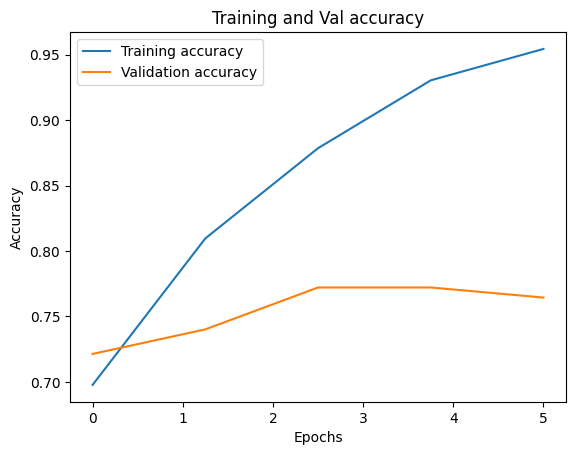

In [ ]:
plt.plot(np.linspace(0, len(history.history['accuracy']), len(history.history['accuracy'])), history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(history.history['val_accuracy']), len(history.history['val_accuracy'])), history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Lower learning rate, lr = 0.00001

In [ ]:
m1 = Sequential([
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu'),
  Dense(3, activation='softmax')])
m1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m1_callback = myCallback(model=m1)
callback.append(m1_callback)

m1_history = m1.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[1])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.5973 - loss: 1.0953 - val_accuracy: 0.6112 - val_loss: 1.0820
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.6210 - loss: 1.0721 - val_accuracy: 0.6112 - val_loss: 1.0239
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - accuracy: 0.6188 - loss: 0.9834 - val_accuracy: 0.6112 - val_loss: 0.9068
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 81s 163ms/step - accuracy: 0.6291 - loss: 0.8807 - val_accuracy: 0.6112 - val_loss: 0.8944
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.6252 - loss: 0.8702 - val_accuracy: 0.6112 - val_loss: 0.8808
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - accuracy: 0.6276 - loss: 0.8533 - val_accuracy: 0.6112 - val_loss: 0.8630
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.6350 - loss: 0.8182 - val_accuracy: 0.6112 - val_loss: 0.8404
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - accuracy: 0.6219 - loss: 0

In [ ]:
m1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 32)              │       2,022,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │           8,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,120,971 (23.35 MB)

 Trainable params: 2,040,323 (7.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,080,648 (15.57 MB)

In [ ]:
#predictions
m1.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.7333 - loss: 0.6114


[0.6094089150428772, 0.7400956153869629]

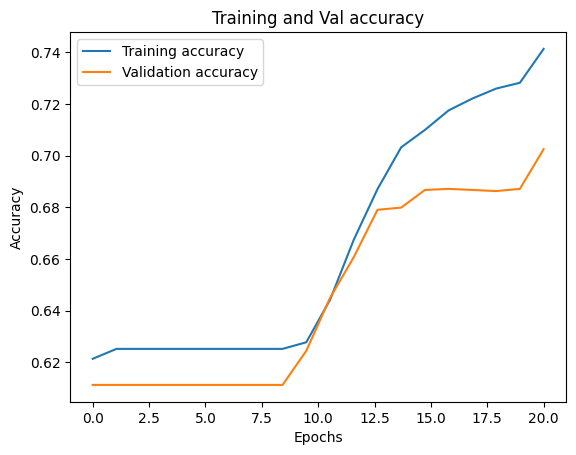

In [ ]:
plt.plot(np.linspace(0, len(m1_history.history['accuracy']), len(m1_history.history['accuracy'])), m1_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m1_history.history['val_accuracy']), len(m1_history.history['val_accuracy'])), m1_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# LSTM layers with small units

In [ ]:
m2 = Sequential([
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu'),
  Dense(3, activation='softmax')])
m2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m2_callback = myCallback(model=m2)
callback.append(m2_callback)

m2_history = m2.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[2])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 54s 171ms/step - accuracy: 0.6093 - loss: 1.0942 - val_accuracy: 0.6112 - val_loss: 1.0749
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.6193 - loss: 1.0569 - val_accuracy: 0.6112 - val_loss: 0.9662
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6303 - loss: 0.9260 - val_accuracy: 0.6112 - val_loss: 0.9120
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.6258 - loss: 0.8921 - val_accuracy: 0.6112 - val_loss: 0.9006
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 168ms/step - accuracy: 0.6252 - loss: 0.8780 - val_accuracy: 0.6112 - val_loss: 0.8830
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.6205 - loss: 0.8619 - val_accuracy: 0.6112 - val_loss: 0.8559
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 168ms/step - accuracy: 0.6239 - loss: 0.8228 - val_accuracy: 0.6112 - val_loss: 0.8158
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 168ms/step - accuracy: 0.6222 - loss: 0

In [ ]:
m2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 32)              │       2,022,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 30, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 30, 16)              │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,124,427 (23.36 MB)

 Trainable params: 2,041,475 (7.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,082,952 (15.58 MB)

In [ ]:
m2.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.7299 - loss: 0.6194


[0.6152717471122742, 0.7414617538452148]

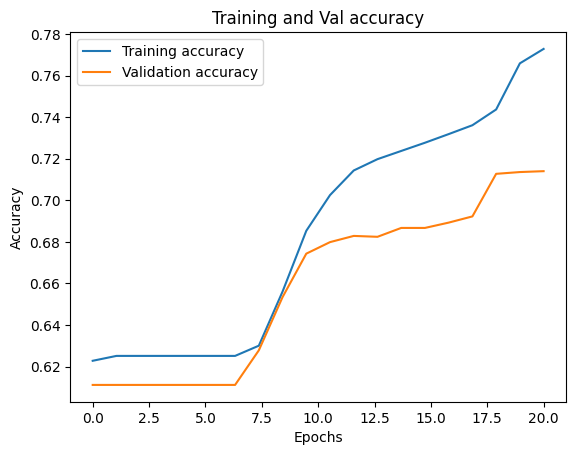

In [ ]:
plt.plot(np.linspace(0, len(m2_history.history['accuracy']), len(m2_history.history['accuracy'])), m2_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m2_history.history['val_accuracy']), len(m2_history.history['val_accuracy'])), m2_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# LSTM layers with more units

In [ ]:
m3 = Sequential([
  LSTM(128, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(64, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu'),
  Dense(3, activation='softmax')])
m3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m3_callback = myCallback(model=m3)
callback.append(m3_callback)

m3_history = m3.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[3])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 52s 166ms/step - accuracy: 0.6038 - loss: 1.0928 - val_accuracy: 0.6112 - val_loss: 1.0318
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6371 - loss: 0.9678 - val_accuracy: 0.6112 - val_loss: 0.9238
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6243 - loss: 0.9007 - val_accuracy: 0.6112 - val_loss: 0.8729
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.6311 - loss: 0.8248 - val_accuracy: 0.6581 - val_loss: 0.7738
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.6917 - loss: 0.7087 - val_accuracy: 0.6778 - val_loss: 0.7341
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.7128 - loss: 0.6450 - val_accuracy: 0.6816 - val_loss: 0.7132
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.7284 - loss: 0.6174 - val_accuracy: 0.6983 - val_loss: 0.6988
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.7352 - loss: 0

In [ ]:
m3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 30, 128)             │       8,140,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 30, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,631,115 (93.96 MB)

 Trainable params: 8,210,371 (31.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,420,744 (62.64 MB)

In [ ]:
m3.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.7412 - loss: 0.6797


[0.6734923720359802, 0.7414617538452148]

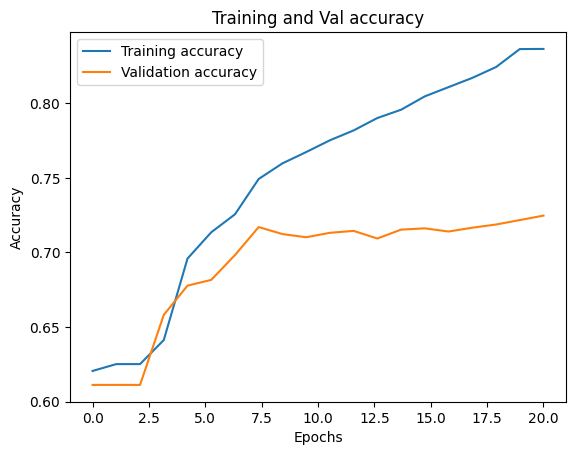

In [ ]:
plt.plot(np.linspace(0, len(m3_history.history['accuracy']), len(m3_history.history['accuracy'])), m3_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m3_history.history['val_accuracy']), len(m3_history.history['val_accuracy'])), m3_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# LSTM with more Dense layers

In [ ]:
m4 = Sequential([
  LSTM(128, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(64, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(3, activation='softmax')])
m4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m4_callback = myCallback(model=m4)
callback.append(m4_callback)

m4_history = m4.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[4])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 53s 168ms/step - accuracy: 0.5916 - loss: 1.0932 - val_accuracy: 0.6112 - val_loss: 1.0310
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6266 - loss: 0.9638 - val_accuracy: 0.6112 - val_loss: 0.9013
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6257 - loss: 0.8722 - val_accuracy: 0.6112 - val_loss: 0.8361
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6313 - loss: 0.7792 - val_accuracy: 0.6714 - val_loss: 0.7467
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.7013 - loss: 0.6822 - val_accuracy: 0.6876 - val_loss: 0.7177
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.7257 - loss: 0.6298 - val_accuracy: 0.6854 - val_loss: 0.6958
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.7271 - loss: 0.5987 - val_accuracy: 0.6880 - val_loss: 0.6810
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.7412 - loss: 0

In [ ]:
m4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 30, 128)             │       8,140,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 30, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,752,843 (94.42 MB)

 Trainable params: 8,250,947 (31.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,501,896 (62.95 MB)

In [ ]:
m4.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.7405 - loss: 0.6898


[0.6796978116035461, 0.75]

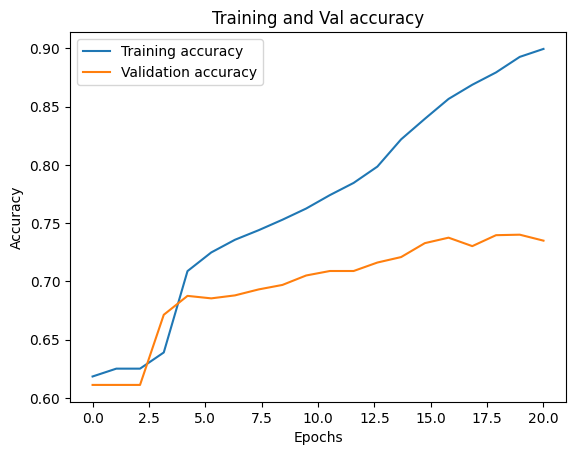

In [ ]:
plt.plot(np.linspace(0, len(m4_history.history['accuracy']), len(m4_history.history['accuracy'])), m4_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m4_history.history['val_accuracy']), len(m4_history.history['val_accuracy'])), m4_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adding Regularization

In [ ]:
m5 = Sequential([
  LSTM(128, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(64, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
  Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
  Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
  Dense(3, activation='softmax')])
m5.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m5_callback = myCallback(model=m5)
callback.append(m5_callback)

m5_history = m5.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[5])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step - accuracy: 0.6212 - loss: 9.5548 - val_accuracy: 0.6112 - val_loss: 9.1306
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.6320 - loss: 8.9629 - val_accuracy: 0.6112 - val_loss: 8.5339
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.6173 - loss: 8.4057 - val_accuracy: 0.6112 - val_loss: 8.0423
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.6315 - loss: 7.8839 - val_accuracy: 0.6112 - val_loss: 7.5207
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - accuracy: 0.6253 - loss: 7.3643 - val_accuracy: 0.6112 - val_loss: 7.0827
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6367 - loss: 6.9113 - val_accuracy: 0.6743 - val_loss: 6.6781
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.7155 - loss: 6.5078 - val_accuracy: 0.6773 - val_loss: 6.3043
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.7247 - loss: 6

In [ ]:
m5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 30, 128)             │       8,140,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 30, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,752,843 (94.42 MB)

 Trainable params: 8,250,947 (31.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,501,896 (62.95 MB)

In [ ]:
m5.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.6993 - loss: 2.8848


[2.8724498748779297, 0.7004781365394592]

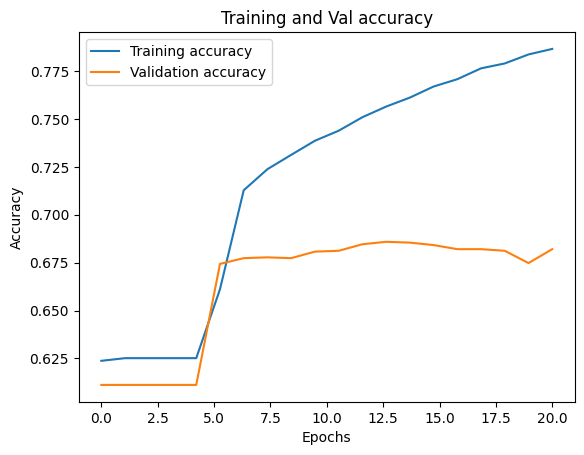

In [ ]:
plt.plot(np.linspace(0, len(m5_history.history['accuracy']), len(m5_history.history['accuracy'])), m5_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m5_history.history['val_accuracy']), len(m5_history.history['val_accuracy'])), m5_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adding dropouts to Dense layers

In [ ]:
m6 = Sequential([
  LSTM(128, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(64, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=True),
  LSTM(16, activation='tanh', input_shape=(max_length, vocab_size), return_sequences=False),
  Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(3, activation='softmax')])
m6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m6_callback = myCallback(model=m6)
callback.append(m6_callback)

m6_history = m6.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[6])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 53s 166ms/step - accuracy: 0.6265 - loss: 9.5584 - val_accuracy: 0.6112 - val_loss: 9.1362
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.6263 - loss: 8.9594 - val_accuracy: 0.6112 - val_loss: 8.5249
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.6161 - loss: 8.4114 - val_accuracy: 0.6112 - val_loss: 8.0339
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.6283 - loss: 7.8910 - val_accuracy: 0.6112 - val_loss: 7.5265
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 165ms/step - accuracy: 0.6220 - loss: 7.3905 - val_accuracy: 0.6112 - val_loss: 7.0965
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.6280 - loss: 6.9457 - val_accuracy: 0.6112 - val_loss: 6.7034
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.6348 - loss: 6.5349 - val_accuracy: 0.6295 - val_loss: 6.3317
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 48s 164ms/step - accuracy: 0.6606 - loss: 6

In [ ]:
m6.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 30, 128)             │       8,140,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 30, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,752,843 (94.42 MB)

 Trainable params: 8,250,947 (31.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,501,896 (62.95 MB)

In [ ]:
m6.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.7064 - loss: 2.9328


[2.9147591590881348, 0.7093579173088074]

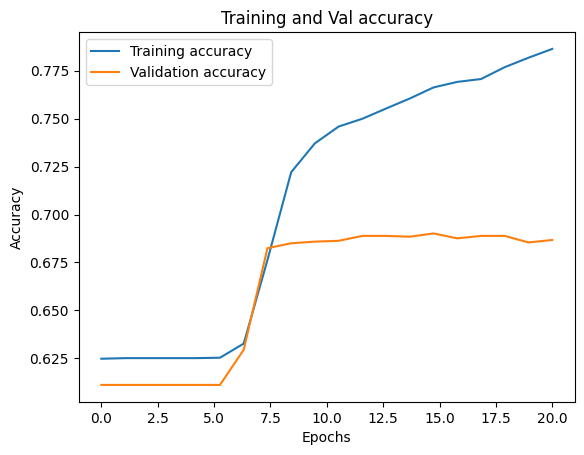

In [ ]:
plt.plot(np.linspace(0, len(m6_history.history['accuracy']), len(m6_history.history['accuracy'])), m6_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m6_history.history['val_accuracy']), len(m6_history.history['val_accuracy'])), m6_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adding dropouts to LSTM layers

In [ ]:
m7 = Sequential([
  LSTM(128, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  LSTM(64, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  LSTM(16, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=False),
  Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(128, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(64, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(3, activation='softmax')])
m7.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m7_callback = myCallback(model=m7)
callback.append(m7_callback)

m7_history = m7.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[7])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 55s 172ms/step - accuracy: 0.6333 - loss: 9.5491 - val_accuracy: 0.6112 - val_loss: 9.1211
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 50s 169ms/step - accuracy: 0.6251 - loss: 8.9551 - val_accuracy: 0.6112 - val_loss: 8.5255
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.6251 - loss: 8.4038 - val_accuracy: 0.6112 - val_loss: 8.0595
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 168ms/step - accuracy: 0.6199 - loss: 7.9404 - val_accuracy: 0.6112 - val_loss: 7.5610
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - accuracy: 0.6205 - loss: 7.4292 - val_accuracy: 0.6112 - val_loss: 7.1264
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.6322 - loss: 6.9818 - val_accuracy: 0.6112 - val_loss: 6.7245
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 50s 172ms/step - accuracy: 0.6199 - loss: 6.5913 - val_accuracy: 0.6112 - val_loss: 6.3606
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 50s 169ms/step - accuracy: 0.6227 - loss: 6

In [ ]:
m7.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 30, 128)             │       8,140,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 30, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,752,843 (94.42 MB)

 Trainable params: 8,250,947 (31.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,501,896 (62.95 MB)

In [ ]:
m7.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.6874 - loss: 2.9285


[2.911325693130493, 0.7001366019248962]

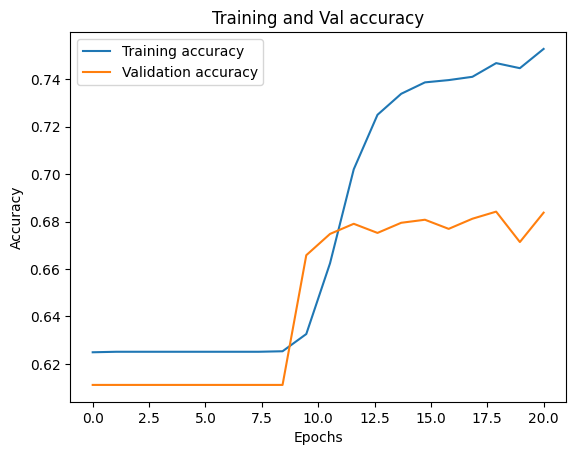

In [ ]:
plt.plot(np.linspace(0, len(m7_history.history['accuracy']), len(m7_history.history['accuracy'])), m7_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m7_history.history['val_accuracy']), len(m7_history.history['val_accuracy'])), m7_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Using L1_L2 Regularizer

In [ ]:
m8 = Sequential([
  LSTM(128, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  LSTM(64, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  LSTM(32, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=True),
  LSTM(16, activation='tanh', input_shape=(max_length, vocab_size), dropout=0.2, return_sequences=False),
  Dense(256, activation='relu', kernel_regularizer=l2(0.03)),
  Dropout(0.2),
  Dense(128, activation='relu', kernel_regularizer=l1_l2(0.03)),
  Dropout(0.2),
  Dense(64, activation='relu', kernel_regularizer=l1_l2(0.03)),
  Dropout(0.2),
  Dense(3, activation='softmax')])
m8.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

m8_callback = myCallback(model=m8)
callback.append(m8_callback)

m8_history = m8.fit(train_generator, epochs=epochs, verbose=1, validation_data=val_generator, callbacks=callback[8])

Epoch 1/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 54s 168ms/step - accuracy: 0.5669 - loss: 84.3103 - val_accuracy: 0.6112 - val_loss: 81.5983
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 165ms/step - accuracy: 0.6326 - loss: 80.7053 - val_accuracy: 0.6112 - val_loss: 78.0547
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 167ms/step - accuracy: 0.6357 - loss: 77.1805 - val_accuracy: 0.6112 - val_loss: 74.5670
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.6230 - loss: 73.7173 - val_accuracy: 0.6112 - val_loss: 71.1878
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 168ms/step - accuracy: 0.6110 - loss: 70.3685 - val_accuracy: 0.6112 - val_loss: 67.9047
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.6219 - loss: 67.0997 - val_accuracy: 0.6112 - val_loss: 64.7066
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 50s 169ms/step - accuracy: 0.6277 - loss: 63.9221 - val_accuracy: 0.6112 - val_loss: 61.5896
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 50s 169ms/step - accuracy: 0.

In [ ]:
m8.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                       │ (None, 30, 128)             │       8,140,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 30, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 30, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,752,843 (94.42 MB)

 Trainable params: 8,250,947 (31.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,501,896 (62.95 MB)

In [ ]:
m8.evaluate(test_generator)

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.6291 - loss: 28.4102


[28.399940490722656, 0.6451502442359924]

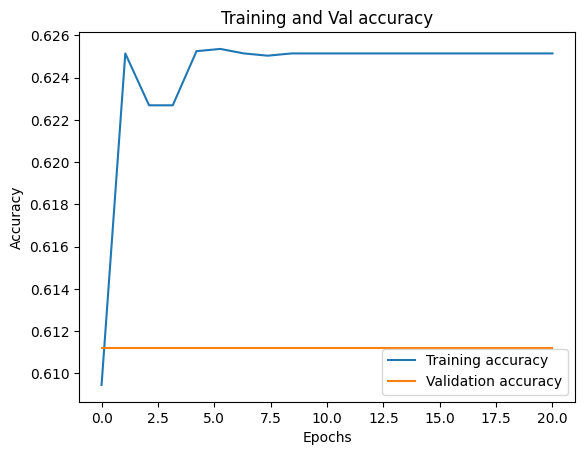

In [ ]:
plt.plot(np.linspace(0, len(m8_history.history['accuracy']), len(m8_history.history['accuracy'])), m8_history.history['accuracy'], label='Training accuracy')
plt.plot(np.linspace(0, len(m8_history.history['val_accuracy']), len(m8_history.history['val_accuracy'])), m8_history.history['val_accuracy'], label = 'Validation accuracy')
plt.title('Training and Val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()